## Install Libraries

In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install unsloth
# Get latest Unsloth
!pip install --upgrade --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# %%

In [3]:
!pip install -q -U datasets

In [2]:
!pip install textattack


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

## Data Augmentation for Sentiment Balancing of Product Reviews

- Loaded AliExpress product reviews and checked label distribution for `positive`, `neutral`, and `negative` sentiments.
- Applied `WordNetAugmenter` to negative and `EmbeddingAugmenter` to neutral samples to balance with the number of positive reviews.
- Combined and shuffled all reviews to prepare a balanced sentiment dataset for training or evaluation.


In [4]:
import pandas as pd
import random
import nltk
from textattack.augmentation import WordNetAugmenter

# Download the necessary nltk resources for WordNet
nltk.download('wordnet')
nltk.download('omw-1.4')

# Unzip the wordnet.zip file without interactive prompts
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!unzip -o /usr/share/nltk_data/corpora/omw.zip -d /usr/share/nltk_data/corpora/


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_d

In [5]:
import pandas as pd
import random
from tqdm import tqdm
from textattack.augmentation import WordNetAugmenter, EmbeddingAugmenter

# Load the dataset from a CSV file
df = pd.read_csv('/kaggle/input/final-sentiment-analysis-dataset/Product Review Of AliExpress SENTIMENT Processed.csv')
df = df[['reviewContent', 'sentiment']]

# Display initial data and label counts
print("Updated Dataset:")
print(df.head())
print("\nOriginal Label Counts:")
print(df['sentiment'].value_counts())

# Initialize augmenters
aug1 = WordNetAugmenter()
aug2 = EmbeddingAugmenter()

# Desired number of samples (same as number of positive samples)
num_target = len(df[df['sentiment'] == 'positive'])

# Function to augment and return a DataFrame with tqdm
def augment_class(df_class, sentiment_label, augmenter, target_count):
    original_reviews = df_class['reviewContent'].tolist()
    augmented_reviews = []

    print(f"\nAugmenting '{sentiment_label}' reviews using {augmenter.__class__.__name__}...")
    with tqdm(total=target_count, desc=f"Augmenting {sentiment_label}", unit="review") as pbar:
        while len(augmented_reviews) < target_count:
            review = random.choice(original_reviews)
            augmented = augmenter.augment(review)
            for aug_text in augmented:
                if len(augmented_reviews) < target_count:
                    augmented_reviews.append(aug_text)
                    pbar.update(1)
                else:
                    break

    return pd.DataFrame({'reviewContent': augmented_reviews, 'sentiment': sentiment_label})

# Original positive reviews (keep as-is)
positive_df = df[df['sentiment'] == 'positive']

# Augment negative reviews using WordNetAugmenter
negative_df = df[df['sentiment'] == 'negative']
augmented_negative_df = augment_class(negative_df, 'negative', aug1, num_target)

# Augment neutral reviews using EmbeddingAugmenter
neutral_df = df[df['sentiment'] == 'neutral']
augmented_neutral_df = augment_class(neutral_df, 'neutral', aug2, num_target)

# Combine all to get balanced dataset
balanced_df = pd.concat([positive_df, augmented_negative_df, augmented_neutral_df], ignore_index=True)

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display results
print("\nBalanced Label Counts:")
print(balanced_df['sentiment'].value_counts())

print("\nBalanced Dataset (Sample):")
print(balanced_df.head())


Updated Dataset:
                                       reviewContent sentiment
0                  Small, it won't work for the car.  negative
1  Very satisfied with the product, it is really ...  positive
2             Very satisfied with this little vacuum  positive
3               Just a bomb! Works like a hurricane!  negative
4          This thing is a monster. Worth every coin  negative

Original Label Counts:
sentiment
positive    8801
neutral     2101
negative    2014
Name: count, dtype: int64
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:37<00:00, 12.9MB/s]   
textattack: Unzipping file /root/.cache/textattack/tmpeh3jxdbb.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.



Augmenting 'negative' reviews using WordNetAugmenter...


Augmenting negative: 100%|██████████| 8801/8801 [42:39<00:00,  3.44review/s]  



Augmenting 'neutral' reviews using EmbeddingAugmenter...


Augmenting neutral: 100%|██████████| 8801/8801 [2:21:38<00:00,  1.04review/s]   


Balanced Label Counts:
sentiment
neutral     8801
negative    8801
positive    8801
Name: count, dtype: int64

Balanced Dataset (Sample):
                                       reviewContent sentiment
0                                  It's as sketched.   neutral
1  The cause were sent dented, because they are p...  negative
2  It is not how much is in the photo, the qualit...  negative
3   Not sure if it can protect a phone considerably…  negative
4  The garnum lawsuits is not too hoot. Wear a ho...   neutral


In [7]:
balanced_df.to_csv('Final balanced dataset.csv',index='false')

In [8]:
# Shuffle the dataset
shuffled_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [8]:
df=balanced_df
df.head(10)

,reviewContent,sentiment
0,It's as sketched.,neutral
1,"The cause were sent dented, because they are p...",negative
2,"It is not how much is in the photo, the qualit...",negative
3,Not sure if it can protect a phone considerably…,negative
4,The garnum lawsuits is not too hoot. Wear a ho...,neutral
5,lovely and colourful \nwill buy more,positive
6,"The color represent to the picture, the fasten...",negative
7,"Having taken on 12/27/24, having denied in Ukr...",neutral
8,"Very good quality, good price",positive
9,I haven’t recibe the bundle,neutral


In [4]:
import pandas as pd
df = pd.read_csv('/kaggle/input/final-sentiment-analysis-dataset/Final balanced dataset.csv')
df = df[['reviewContent', 'sentiment']]
df.head()

,reviewContent,sentiment
0,It's as sketched.,neutral
1,"The cause were sent dented, because they are p...",negative
2,"It is not how much is in the photo, the qualit...",negative
3,Not sure if it can protect a phone considerably…,negative
4,The garnum lawsuits is not too hoot. Wear a ho...,neutral


## Splitting Balanced Sentiment Data into Train, Test, and Eval Sets

- Performed stratified splitting for each sentiment class into 5,500 training and 3,000 testing samples.
- Generated a small evaluation set by sampling 50 reviews per sentiment not included in train/test.
- Ensured randomness and reproducibility using fixed `random_state` values.


In [5]:
from sklearn.model_selection import train_test_split
X_train = list()
X_test = list()
for sentiment in ["positive", "negative","neutral"]:
    train, test  = train_test_split(df[df.sentiment==sentiment],
                                    train_size=5500,
                                    test_size=3000,
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(train.index) + list(test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

/tmp/ipykernel_31/3253046990.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))


## Generating Prompt-Based Format for Sentiment Analysis

- Converted `reviewContent` into instruction-style prompts for both training and testing.
- Applied prompt templates for few-shot learning and consistent evaluation.
- Transformed train and eval data into Hugging Face `Dataset` objects for model training.


In [6]:
# Function to generate the prompt for training data
def generate_prompt(data_point):
    return f"""
            Determine if the review enclosed in square brackets is positive, neutral or negative based on its content.
            Return the answer as either "positive", "neutral" or "negative".

            [{data_point["reviewContent"]}] = {data_point["sentiment"]}
            """.strip()



In [7]:
from datasets import Dataset
# Function to generate the prompt for testing data
def generate_test_prompt(data_point):
    return f"""
            Determine if the review enclosed in square brackets is positive, neutral or negative based on its content.
            Return the answer as either "positive", "neutral" or "negative".

            [{data_point["reviewContent"]}] =
            """.strip()

# Assuming X_train, X_eval, and X_test are pandas DataFrames containing the 'reviewContent' and 'label' columns
# Apply the prompt generation function to the training and evaluation data
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), columns=["reviewContent"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), columns=["reviewContent"])

# The labels for the true values (test set) would be used for evaluation
y_true = X_test['sentiment']

# Generate test prompts for the test set
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["reviewContent"])

# Convert to Hugging Face datasets
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)


## Evaluation Function for Sentiment Classification

- Calculates overall accuracy, per-class accuracy, classification report, and confusion matrix.
- Maps string sentiment labels (`positive`, `neutral`, `negative`) to numerical values for evaluation.
- Helps assess model performance across all sentiment categories.


In [8]:
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
import numpy as np
def evaluate(y_true, y_pred):
    labels = ['positive','neutral', 'negative']
    mapping = {'positive': 0, 'neutral':1, 'negative': 2}
    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    print('\nConfusion Matrix:')
    print(conf_matrix)

## Loading Pre-trained Mistral-7B 4-bit Model with Unsloth

- Loads the `mistral-7b-bnb-4bit` model using Unsloth with 4-bit quantization for memory-efficient training.
- Initializes tokenizer and prepares model for fine-tuning.
- Identifies all 4-bit linear layers (excluding `lm_head`) for applying LoRA adaptation.


In [9]:
import unsloth
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-bnb-4bit", 
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-04-12 05:29:59.741979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744435799.947052      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744435800.005257      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mistral patching. Transformers: 4.51.1.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

In [10]:
import bitsandbytes as bnb
def find_all_linear_names(model):
  cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
  lora_module_names = set()
  for name, module in model.named_modules():
    if isinstance(module, cls):
      names = name.split('.')
      lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names: # needed for 16-bit
      lora_module_names.remove('lm_head')
  return list(lora_module_names)

In [11]:
modules = find_all_linear_names(model)
print(modules)

['up_proj', 'q_proj', 'o_proj', 'gate_proj', 'k_proj', 'down_proj', 'v_proj']


## Prediction Function for Sentiment Classification

- Iterates through test prompts and generates predictions using the fine-tuned model.
- Decodes model output and extracts sentiment label (`positive`, `neutral`, or `negative`).
- Uses tqdm for progress visualization during batch inference.


In [13]:
from tqdm import tqdm
def predict(X_test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["reviewContent"]
        input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs= model.generate(**input_ids,pad_token_id=tokenizer.eos_token_id, max_new_tokens=1,temperature=0.0)
        result = tokenizer.decode(outputs[0])
        answer = result.split("=")[-1].lower()
        if "positive" in answer:
            y_pred.append("positive")
        elif "neutral" in answer:
            y_pred.append("neutral")
        elif "negative" in answer:
            y_pred.append("negative")
        else:
            y_pred.append("none")
    return y_pred

## Sentiment Prediction and Evaluation

- Uses a `predict` function to generate sentiment predictions from test prompts using the fine-tuned model.
- Evaluates predictions with accuracy, classification report, and confusion matrix.
- Initial results show strong prediction for "positive" and "negative", but weak performance on "neutral".
# Pre Training Evaluation

In [20]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 9000/9000 [51:09<00:00,  2.93it/s] 


In [21]:
evaluate(y_true, y_pred)

Accuracy: 0.626
Accuracy for label 0: 0.969
Accuracy for label 1: 0.094
Accuracy for label 2: 0.815

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.97      0.69      3000
           1       0.62      0.09      0.16      3000
           2       0.78      0.81      0.80      3000

    accuracy                           0.63      9000
   macro avg       0.65      0.63      0.55      9000
weighted avg       0.65      0.63      0.55      9000


Confusion Matrix:
[[2907   45]
 [2093  282]]


## Fine-Tuning Mistral-7B for Sentiment Classification

- LoRA is applied to Mistral-7B using `FastLanguageModel.get_peft_model` with 64 rank and gradient checkpointing.
- Fine-tuned using `trl.SFTTrainer` over two epochs with small batches and 8-bit optimizer.
- Training loss is visualized to monitor convergence and model performance.


In [14]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = modules,
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [18]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset=train_data,
    eval_dataset=eval_data,
    dataset_text_field = "reviewContent",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 2,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 100,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

Unsloth: Tokenizing ["reviewContent"] (num_proc=2):   0%|          | 0/16500 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["reviewContent"] (num_proc=2):   0%|          | 0/150 [00:00<?, ? examples/s]

In [19]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla P100-PCIE-16GB. Max memory = 15.888 GB.
6.883 GB of memory reserved.


In [20]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16,500 | Num Epochs = 2 | Total steps = 4,124
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 167,772,160/7,000,000,000 (2.40% trained)


Step,Training Loss
100,0.987800
200,0.861200
300,0.800300
400,1.084800
500,1.145500
600,1.077100
700,1.126900
800,1.090000
900,1.051300
1000,1.020000


In [25]:
trainer_stats

TrainOutput(global_step=4124, training_loss=0.713483151594027, metrics={'train_runtime': 31383.6208, 'train_samples_per_second': 1.052, 'train_steps_per_second': 0.131, 'total_flos': 1.2801606523261747e+17, 'train_loss': 0.713483151594027})

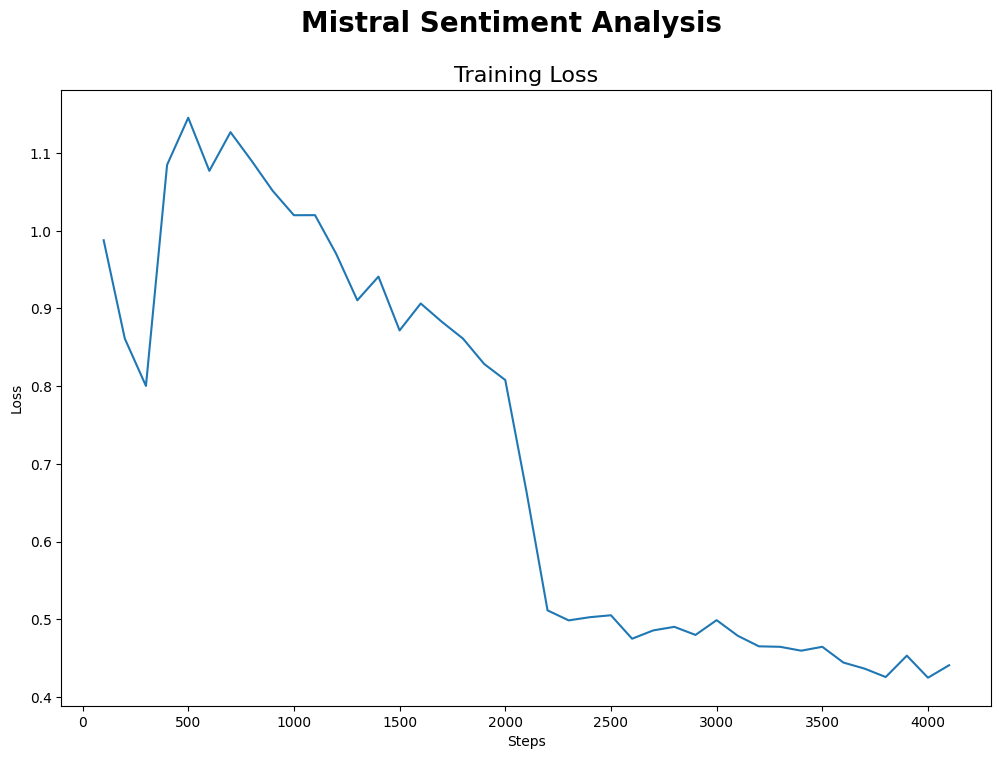

In [ ]:
import matplotlib.pyplot as plt

# Extract the training losses from the log history
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
# Extract the steps from the log history
steps = [log["step"] for log in trainer.state.log_history if "loss" in log]


# Create the figure with larger size
plt.figure(figsize=(12, 8))  # Adjust the width and height (in inches)

# Plotting the loss curve
plt.plot(steps, losses)

# Adding a heading for the figure
plt.suptitle("Mistral Sentiment Analysis", fontsize=20, fontweight='bold')

# Adding the title, axis labels, and displaying the plot
plt.title("Training Loss", fontsize=16)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Loss", fontsize=10)

# Display the plot
plt.show()

In [27]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

31383.6208 seconds used for training.
523.06 minutes used for training.
Peak reserved memory = 6.883 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 43.322 %.
Peak reserved memory for training % of max memory = 0.0 %.


## Post-Evaluation Metrics for Fine-Tuned Sentiment Model

- Achieved **97.5% overall accuracy** on a balanced test set of 9,000 reviews.
- Class-wise accuracy: **Positive (98.4%)**, **Neutral (95.8%)**, **Negative (98.4%)**.
- Classification report and confusion matrix confirm high precision and recall across all classes.


In [29]:
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)


100%|██████████| 9000/9000 [58:47<00:00,  2.55it/s]  

Accuracy: 0.975
Accuracy for label 0: 0.984
Accuracy for label 1: 0.958
Accuracy for label 2: 0.984

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3000
           1       0.98      0.96      0.97      3000
           2       0.97      0.98      0.98      3000

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000


Confusion Matrix:
[[2951   32]
 [  50 2873]]


## Saving and Uploading the Fine-Tuned Sentiment Model

- Saved the fine-tuned **Mistral-7B** model locally under `"Sentiment Analysis Mistral 7B Fine Tuned"`.
- Pushed the model to Hugging Face Hub under the repository:
  `AbuSalehMd/Sentiment_Analysis_Mistral_7B_FineTuned` for public or team use.


In [37]:
model.save_pretrained("Sentiment Analysis Mistral 7B Fine Tuned")

In [ ]:
model.push_to_hub("AbuSalehMd/Sentiment_Analysis_Mistral_7B_FineTuned", token = "hf_XXXXX") # Online saving

README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Saved model to https://huggingface.co/AbuSalehMd/Sentiment_Analysis_Mistral_7B_FineTuned
